# *I. Dataset và mô tả dataset*

Download necessary libraries

In [2]:
!git clone  https://github.com/takaniwa/DSNet.git

Cloning into 'DSNet'...
remote: Enumerating objects: 711, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 711 (delta 147), reused 295 (delta 80), pack-reused 309 (from 1)
Receiving objects: 100% (711/711), 3.55 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (308/308), done.


In [3]:
!pip install thop
!pip install yacs

Download dataset

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("xiaose/cityscapes")

# print("Path to dataset files:", path)

In [4]:
import sys
sys.path.append('/kaggle/working/DSNet')

In [5]:
import os
import timeit
import random
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from collections import Counter

from models.dsnet import DSNet
from utils.criterion import OhemCrossEntropy, CrossEntropy
from utils.utils import FullModel, AverageMeter, adjust_learning_rate

Dataset dùng cho bài toán Image Segmentation, gồm 19 lớp chính như đường, lề đường, tòa nhà, người, xe, v.v. Mỗi lớp được ánh xạ với một màu RGB cụ thể để trực quan hóa.

* Semantic Segmentation: Phân lớp toàn cảnh dựa trên color_map.
* Instance Segmentation: Phân biệt các đối tượng như người, xe bằng ID thang xám trong instance_color.
* Label Mapping: Chuyển nhãn từ dataset gốc sang nhãn phù hợp, với các lớp không liên quan được gán -1 để bỏ qua.

In [6]:
color_map = np.array([
    [128, 64, 128],   # 0: Road
    [244, 35, 232],   # 1: Sidewalk
    [ 70, 70, 70],    # 2: Building
    [102, 102, 156],  # 3: Wall
    [190, 153, 153],  # 4: Fence
    [153, 153, 153],  # 5: Pole
    [250, 170, 30],   # 6: Traffic light
    [220, 220, 0],    # 7: Traffic sign
    [107, 142, 35],   # 8: Vegetation
    [152, 251, 152],  # 9: Terrain
    [70, 130, 180],   # 10: Sky
    [220, 20, 60],    # 11: Person
    [255, 0, 0],      # 12: Rider
    [0, 0, 142],      # 13: Car
    [0, 0, 70],       # 14: Truck
    [0, 60, 100],     # 15: Bus
    [0, 80, 100],     # 16: Train
    [0, 0, 230],      # 17: Motorcycle
    [119, 11, 32],    # 18: Bicycle
], dtype=np.uint8)

instance_id = [11, 12, 13, 14, 15, 16, 17, 18]

instance_color = np.array([
    [93],    # 11: Person
    [97],    # 12: Rider
    [101],    # 13: Car
    [105],    # 14: Truck
    [109],    # 15: Bus
    [121],    # 16: Train
    [125],    # 17: Motorcycle
    [128],    # 18: Bicycle
], dtype=np.uint8)

label_mapping = {
    -1: -1, 0: -1, 1: -1,
    2: -1, 3: -1, 4: -1,
    5: -1, 6: -1, 7: 0,
    8: 1, 9: -1, 10: -1,
    11: 2, 12: 3, 13: 4,
    14: -1, 15: -1, 16: -1,
    17: 5, 18: -1, 19: 6,
    20: 7, 21: 8, 22: 9,
    23: 10, 24: 11, 25: 12,
    26: 13, 27: 14, 28: 15,
    29: -1, 30: -1, 31: 16,
    32: 17, 33: 18,
}

CityscapesDataset để xử lý dữ liệu từ tập dữ liệu Cityscapes, hỗ trợ việc tải và tiền xử lý dữ liệu.

Chức năng chính:
1. Khởi tạo và chuẩn bị dữ liệu:
* Xác định đường dẫn dữ liệu (ảnh và nhãn) theo chế độ (train, val, test).
* Đọc và sắp xếp danh sách tệp ảnh (image_files) và nhãn (label_files).
* Kiểm tra tính đồng nhất của số lượng ảnh và nhãn, và cảnh báo nếu không khớp.
2. Kích thước tập dữ liệu:
* Cung cấp tổng số mẫu qua hàm __len__.
3. Truy xuất dữ liệu mẫu:
* Tải một cặp ảnh và nhãn tương ứng qua chỉ số idx (hàm __getitem__).
* Hỗ trợ lật ngang ngẫu nhiên ảnh và nhãn theo xác suất flip_prob.
* Chuyển đổi ảnh với các phép biến đổi bổ sung (nếu cung cấp).
* Gán lại các giá trị nhãn dựa trên ánh xạ (mapping) tùy chỉnh, sau đó chuyển đổi sang định dạng tensor.

In [7]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train' , transform=None, flip_prob=0.5):
        self.root_dir = root_dir
        self.split = split
        
        self.img_dir = os.path.join(root_dir, 'images', split)
        self.label_dir = os.path.join(root_dir, 'gtFine', split)
        
        self.image_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.img_dir)) for f in fn if f.endswith('.png')])
        self.label_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.label_dir)) for f in fn if f.endswith('_labelIds.png')])
        
        self.transform = transform
        self.flip_prob = flip_prob
        
        if len(self.image_files) != len(self.label_files):
            print("Warning: Number of images and labels do not match!")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = self.label_files[idx]
        
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        
        # Apply flip with the given probability
        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Apply any additional transforms (e.g., resizing, normalization, etc.)
        if self.transform:
            image = self.transform(image)
        
        label = np.array(label, dtype=np.int64)
        label = np.vectorize(label_mapping.get)(label)  # Apply label mapping if needed
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

Thống kê dữ liệu, in ra vài ảnh và nhãn của chúng

In [8]:
def analyze_and_visualize_dataset(dataset, num_samples=5, dataset_name="Dataset"):
    # 1. Data Statistics
    print(f"----- {dataset_name} Statistics -----")
    print(f"Number of samples: {len(dataset)}")

    # 2. Visualization
    print(f"\n----- Visualizing {num_samples} Samples from {dataset_name} -----")
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Convert tensor to numpy for visualization
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()

        if isinstance(label, torch.Tensor):
            label = label.numpy()

        # Plot image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image {idx}")
        axes[i, 0].axis('off')

        # Plot label
        axes[i, 1].imshow(label, cmap='nipy_spectral')
        axes[i, 1].set_title(f"Label {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
dataset_path = "/kaggle/input/cityscapes/Cityspaces"
train_dataset = CityscapesDataset(root_dir=dataset_path, split='train')
val_dataset = CityscapesDataset(root_dir=dataset_path, split='val')

----- Train dataset Statistics -----
Number of samples: 2975

----- Visualizing 2 Samples from Train dataset -----


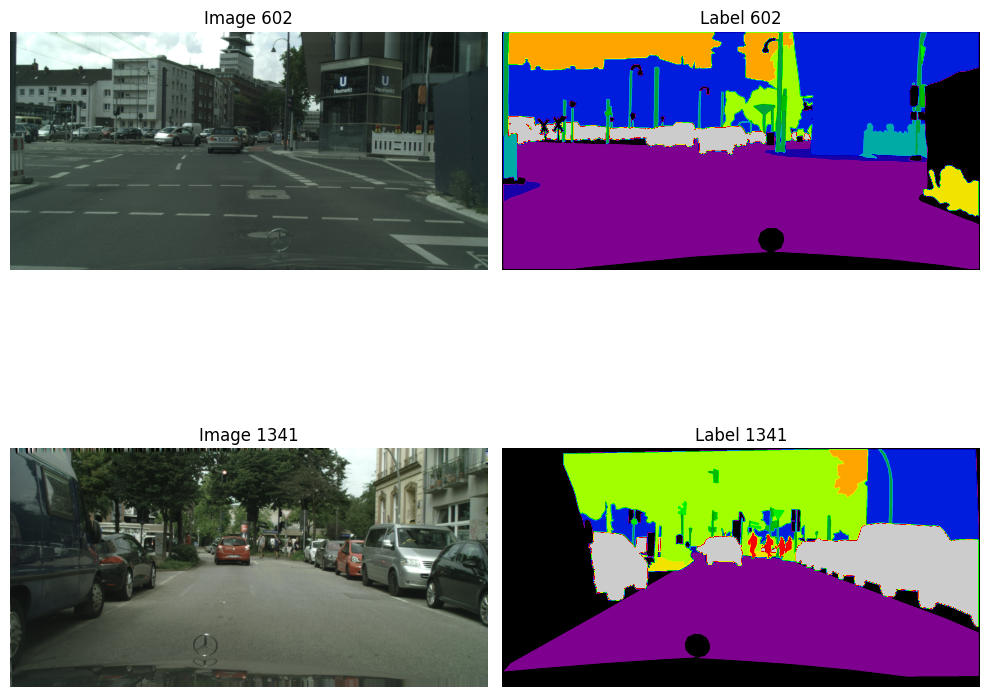

In [10]:
analyze_and_visualize_dataset(train_dataset, num_samples=2, dataset_name="Train dataset")

----- Validation dataset Statistics -----
Number of samples: 500

----- Visualizing 2 Samples from Validation dataset -----


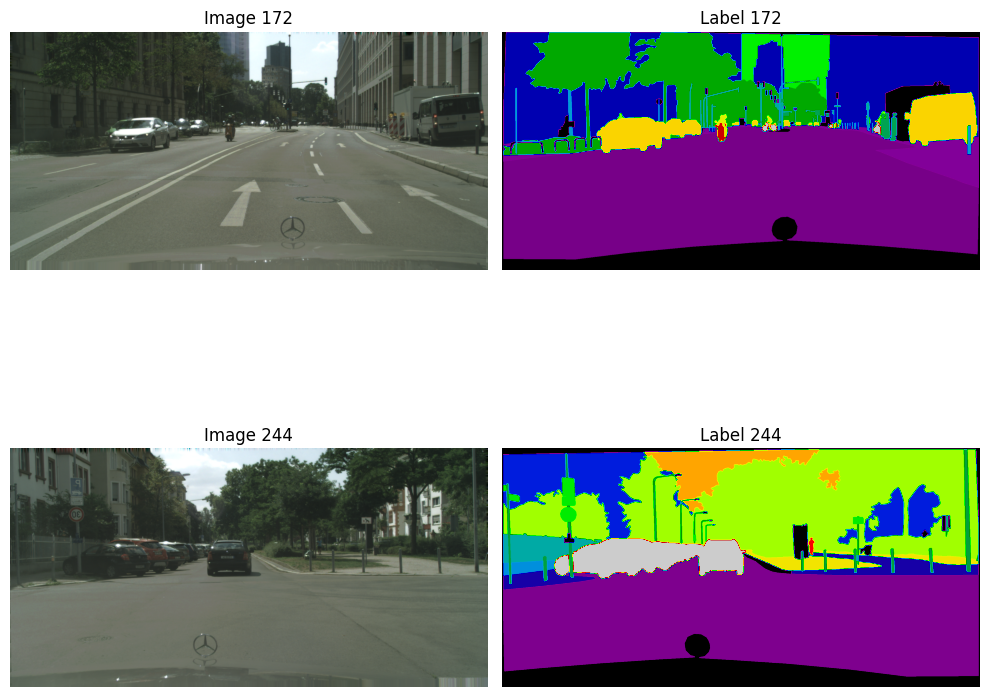

In [11]:
analyze_and_visualize_dataset(val_dataset, num_samples=2, dataset_name="Validation dataset")

# II.Mô hình


### Setup

Hàm get_sampler được sử dụng để quyết định việc phân phối dữ liệu trong các môi trường huấn luyện phân tán (distributed training). Nó kiểm tra liệu hệ thống có đang chạy trong môi trường phân tán hay không bằng cách gọi hàm is_distributed() từ module utils.distributed.

In [10]:
def get_sampler(dataset):
    from utils.distributed import is_distributed
    if is_distributed():
        from torch.utils.data.distributed import DistributedSampler
        return DistributedSampler(dataset)
    else:
        return None

#### **1. Cấu hình cơ bản**
- **Số epoch (`epochs`)**: 50, mô hình sẽ huấn luyện qua 50 chu kỳ trên tập dữ liệu.
- **Learning rate (`lr`)**: 0.0001, sử dụng để cập nhật trọng số trong quá trình huấn luyện.
- **Kích thước ảnh huấn luyện (`train_image_size`)**: 512x1024, tất cả ảnh đầu vào sẽ được resize về kích thước này.
- **Kích thước batch (`batch_size`)**: 4, mô hình xử lý 4 mẫu dữ liệu trong một batch.
- **Shuffle**: True, đảm bảo dữ liệu huấn luyện được xáo trộn trong mỗi epoch, tăng khả năng tổng quát hóa.

---

#### **2. Tiền xử lý dữ liệu (Data Transformation)**
Sử dụng `torchvision.transforms` để áp dụng các bước tiền xử lý cho dữ liệu đầu vào:
1. **Resize**: Thay đổi kích thước ảnh về (512, 1024).
2. **ToTensor**: Chuyển đổi ảnh từ định dạng numpy hoặc PIL thành tensor PyTorch.
3. **Normalize**: Chuẩn hóa ảnh với các giá trị trung bình và độ lệch chuẩn:
   - Mean: `[0.485, 0.456, 0.406]` (giá trị trung bình của ImageNet).
   - Std: `[0.229, 0.224, 0.225]`.

---

#### **3. Trọng số lớp (Class Weights)**
Sử dụng trọng số lớp để cân bằng mất mát (loss) giữa các lớp trong bài toán phân đoạn.  
- **Ý nghĩa**: Cân bằng ảnh hưởng của các lớp phổ biến và hiếm gặp trong tập dữ liệu.
- **Trọng số**: 
  - Ví dụ: Lớp 1 có trọng số `0.8373`, lớp 19 có trọng số `1.0507`. 
  - Giá trị này giúp các lớp hiếm (trọng số cao) đóng vai trò quan trọng hơn trong tối ưu hóa.

In [11]:
# Config train
train_image_size = [512, 1024]
batch_size = 4
shuffle = True
epochs = 200
lr = 0.0001

transform = transforms.Compose([
    transforms.Resize((train_image_size[0], train_image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345, 
                                        1.0166, 0.9969, 0.9754, 1.0489,
                                        0.8786, 1.0023, 0.9539, 0.9843, 
                                        1.1116, 0.9037, 1.0865, 1.0955, 
                                        1.0865, 1.1529, 1.0507]).cuda()

Tạo bộ dữ liệu huấn luyện

In [12]:
subset_indices = list(range(250))
train_set = CityscapesDataset(root_dir=dataset_path, split='train', transform=transform, flip_prob=0.4)
train_subset = Subset(train_set, subset_indices)
train_sampler = get_sampler(train_subset)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True, drop_last=True, sampler=train_sampler)

In [ ]:
model = DSNet(m=2, n=2, num_classes=19, planes=32, name='s256', augment=True)
model = nn.DataParallel(model, device_ids=[0, 1])

In [81]:
criterion = OhemCrossEntropy(weight=class_weights)
# config loss
MOMENTUM = 0.95
WD = 0.0001
optimizer = torch.optim.SGD(model.parameters(),
                        lr=0.0001,
                        momentum=MOMENTUM,
                        weight_decay=WD,
                        nesterov=False,
                        )

In [82]:
def save_model(model, file_path):
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Lưu mô hình
    torch.save(model.state_dict(), file_path)
    print(f"Mô hình đã được lưu tại {file_path}")

In [83]:
def calculate_PA(output, target):
    """Tính Pixel Accuracy (PA)."""
    # Dự đoán lớp có xác suất cao nhất tại mỗi pixel
    predicted = torch.argmax(output, dim=1)
    
    # Tạo mặt nạ cho các pixel hợp lệ (target != -1)
    valid_pixels = (target != -1)

    # Đếm số pixel dự đoán đúng trên các pixel hợp lệ
    correct = torch.sum((target == predicted) & valid_pixels)
    total = torch.sum(valid_pixels)  # Tổng số pixel hợp lệ

    # Tính Pixel Accuracy
    if total > 0:
        return correct.float() / total.float()  # Chuyển sang kiểu float để tránh chia lấy nguyên
    else:
        return 0.0

def calculate_iou(output, target, num_classes):
    with torch.no_grad():
        # Lấy nhãn dự đoán bằng cách lấy argmax theo chiều classes
        predicted = torch.argmax(output, dim=1)  # [batch_size, height, width]

        # Tạo tensor để lưu trữ tổng IoU cho từng lớp
        ious = []

        # Lấy các lớp xuất hiện trong predicted và target
        classes_in_true = torch.unique(target)
        classes_in_pred = torch.unique(predicted)

        # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
        classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

        # Tính IoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
        for cls in classes_in_true_no_neg1:
            cls = cls.item()  # Chuyển sang kiểu int để sử dụng như chỉ mục

            # Mask cho từng lớp
            pred_mask = (predicted == cls)
            true_mask = (target == cls)

            # Tính Intersection và Union
            intersection = torch.sum(pred_mask & true_mask).item()
            union = torch.sum(pred_mask | true_mask).item()

            if union == 0:
                ious.append(float('nan'))  # Nếu không có pixel nào thuộc lớp đó
            else:
                ious.append(intersection / union)

        # Tính IoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` mà không có trong `y_true`
        neg1_pixels = (target == -1)
        if torch.sum(neg1_pixels) > 0:
            pred_classes_not_in_true = torch.tensor(
                [cls for cls in classes_in_pred if cls not in classes_in_true_no_neg1],
                device=target.device
            )

            # Tính IoU cho các pixel lớp -1
            pred_mask_neg1 = torch.isin(predicted, pred_classes_not_in_true)  # Chỉ có trên PyTorch 1.10+
            intersection_neg1 = torch.sum(neg1_pixels & pred_mask_neg1).item()
            union_neg1 = torch.sum(neg1_pixels | pred_mask_neg1).item()

            if union_neg1 == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection_neg1 / union_neg1)

    # Tính mIoU bằng cách lấy trung bình các IoU, bỏ qua giá trị NaN
    return np.nanmean(ious)

In [84]:
def train(model, train_loader, criterion, optimizer, num_epochs, device, save_path, alpha=1, beta=2):
    best_loss, best_iou = float('inf'), float('inf')
    losses = []
    losses_crossr_entropy = []
    losses_iou = []
    pixel_acc = []
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []
        epoch_ohem_loss = 0.0
        epoch_iou_loss = []
        epoch_pa = 0.0
        total_batch = len(train_loader)

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            output_resized = [F.interpolate(outputs[i], size=(1024, 2048), mode='bilinear', align_corners=False) for i in range(3)]
            
            loss1 = criterion(output_resized[0], labels)
            loss2 = criterion(output_resized[1], labels)
            loss3 = criterion(output_resized[2], labels)
            
            ohem_loss = (loss1 + loss2 + loss3) / 3
            epoch_ohem_loss += ohem_loss
            
            iou_loss = 1 -  calculate_iou(output_resized[2], labels, 19)
            epoch_iou_loss.append(iou_loss)
            
            epoch_pa += calculate_PA(output_resized[0], labels)
            
            total_loss = alpha * ohem_loss + beta * iou_loss
            
            total_loss.backward()
            optimizer.step()
            
            epoch_loss.append(total_loss.item())
        
        # Lưu thông tin epoch
        losses.append(np.mean(epoch_loss))
        losses_crossr_entropy.append(epoch_ohem_loss / total_batch)
        pixel_acc.append(epoch_pa / total_batch)
        losses_iou.append(np.mean(epoch_iou_loss))
        
        print(f"Loss: {losses[-1]:.4f}, Ohem Loss: {losses_crossr_entropy[-1]:.4f}, IoU Loss: {losses_iou[-1]:.4f}, Pixel Accuracy: {pixel_acc[-1]:.4f}")

        
        # Lưu mô hình nếu loss giảm
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            save_model(model, save_path) # Assuming you have a save_model function
            print(f"Model saved at epoch {epoch+1} with Loss: {best_loss:.4f}, Ohem Loss: {losses_crossr_entropy[-1]:.4f}, IoU Loss: {losses_iou[-1]:.4f}, Pixel Accuracy: {pixel_acc[-1]:.4f}")
    
    return losses, losses_crossr_entropy, losses_iou, pixel_acc

In [ ]:
total_losses, ohem_losses, iou_losses, pixel_acc = train(model, train_loader, criterion, optimizer, epochs, 'cuda', "/kaggle/working/model.pth")

In [ ]:
plt.figure(figsize=(15, 15))

print(f'Total loss: {total_losses[-1]:.4f}, Ohem loss: {ohem_losses[-1]:.4f}, IoU loss: {iou_losses[-1]:.4f}, Pixel Accuracy: {pixel_acc[-1]:.4f}')

plt.subplot(2, 2, 1)
plt.plot(total_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Loss")

plt.subplot(2, 2, 2)
ohem_losses_tensor = torch.tensor(ohem_losses)
ohem_losses_tensor = ohem_losses_tensor.to('cuda')
ohem_losses = ohem_losses_tensor.cpu().numpy()
plt.plot(ohem_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Ohem Cross Entropy Loss")

plt.subplot(2, 2, 3)
plt.plot(iou_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("IoU Loss")

plt.subplot(2, 2, 4)
pixel_acc_tensor = torch.tensor(pixel_acc)
pixel_acc_tensor = pixel_acc_tensor.to('cuda')
pixel_acc = pixel_acc_tensor.cpu().numpy()
plt.plot(pixel_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Pixel Accuracy")

# Test model DSNet

In [15]:
def get_confusion_matrix(label, pred, size, num_class=19, ignore=-1):
    output = pred.cpu().numpy().transpose(0, 2, 3, 1)
    seg_pred = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
    seg_gt = np.asarray(
    label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=np.int64)

    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]

    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((num_class, num_class))

    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                confusion_matrix[i_label,
                                 i_pred] = label_count[cur_index]
    return confusion_matrix

In [16]:
def validate(model, testloader, criterion, num_classes):
    model.eval()
    model.to('cuda')
    ave_loss = AverageMeter()
    pixel_acc = 0
    confusion_matrix = np.zeros((num_classes, num_classes))
    mean_loss = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(testloader):
            images, labels = batch
            size = labels.size()
            
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = model(images)
            
            if not isinstance(outputs, (list, tuple)):
                outputs = [outputs] 
                
            confusion_matrix += get_confusion_matrix(
                labels,
                outputs[1],
                size
            )
            
            loss = criterion(outputs[0], labels)
            ave_loss.update(loss)
            
    pos = confusion_matrix.sum(1)
    res = confusion_matrix.sum(0)
    tp = np.diag(confusion_matrix)
    pixel_acc = tp.sum()/pos.sum()
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    return ave_loss.average(), mean_IoU, pixel_acc

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = CityscapesDataset(root_dir=dataset_path, split='val', transform=transform)
test_sampler = get_sampler(test_set)
test_loader = DataLoader(test_set, batch_size=1, shuffle=shuffle, num_workers=2, pin_memory=True, drop_last=True, sampler = test_sampler)

# Visualization Output of model

In [36]:
def cal_pixel_accuracy(y_true, y_pred):
    """Tính Pixel Accuracy (PA)."""
    valid_pixels = (y_true != -1)

    # Đếm số pixel dự đoán đúng trên các pixel hợp lệ
    correct = np.sum((y_true == y_pred) & valid_pixels)
    total = np.sum(valid_pixels)  # Tổng số pixel hợp lệ

    # Tính Pixel Accuracy
    if total > 0:
        return correct / total
    else:
        return 0

def cal_mean_pixel_accuracy(y_true, y_pred, num_classes):
    """Tính Mean Pixel Accuracy (mPA)."""
    mpa = 0
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính mPA cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for c in classes_in_true_no_neg1:
        true_class_pixels = (y_true == c)
        pred_class_pixels = (y_pred == c)

        # Tính chính xác cho lớp c
        correct_class_pixels = np.sum(true_class_pixels & pred_class_pixels)
        total_class_pixels = np.sum(true_class_pixels)

        if total_class_pixels > 0:
            class_accuracy = correct_class_pixels / total_class_pixels
            mpa += class_accuracy

    # Tính mPA cho lớp -1 trong `y_true` với các lớp trong `y_pred`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Tìm các lớp có trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính độ chính xác cho lớp -1
        correct_neg1_pixels = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        total_neg1_pixels = np.sum(neg1_pixels)

        # Nếu có pixel thuộc lớp -1
        if total_neg1_pixels > 0:
            neg1_accuracy = correct_neg1_pixels / total_neg1_pixels
            mpa += neg1_accuracy

    # Chia mPA cho tổng số lượng lớp thực tế để lấy trung bình
    mpa = mpa / (len(classes_in_true_no_neg1) + 1)  # +1 để tính lớp -1 riêng
    return mpa

def cal_iou(y_true, y_pred, num_classes):
    """Tính Mean Intersection over Union (mIoU)"""
    ious = []
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính IoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for i in classes_in_true_no_neg1:
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))

        if union == 0:
            ious.append(np.nan)  # Nếu không có pixel nào thuộc lớp đó trong cả y_true và y_pred
        else:
            ious.append(intersection / union)

    # Tính IoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` mà không có trong `y_true`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Lấy các lớp trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính IoU cho các pixel lớp -1
        intersection_neg1 = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        union_neg1 = np.sum(neg1_pixels | np.isin(y_pred, pred_classes_not_in_true))

        if union_neg1 == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection_neg1 / union_neg1)

    # Tính mIoU bằng cách lấy trung bình các IoU, bỏ qua giá trị NaN
    return np.nanmean(ious)

def cal_frequency_weighted_iou(y_true, y_pred, num_classes):
    """Tính Frequency Weighted IoU (FWIoU)."""
    total_pixels = y_true.size
    fwiou = 0
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính FWIoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for i in classes_in_true_no_neg1:
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        freq = np.sum(y_true == i) / total_pixels

        if union > 0:
            fwiou += freq * (intersection / union)

    # Tính FWIoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` không có trong `y_true`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Lấy các lớp trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính intersection và union cho lớp -1
        intersection_neg1 = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        union_neg1 = np.sum(neg1_pixels | np.isin(y_pred, pred_classes_not_in_true))
        freq_neg1 = np.sum(neg1_pixels) / total_pixels

        if union_neg1 > 0:
            fwiou += freq_neg1 * (intersection_neg1 / union_neg1)

    return fwiou

def evaluate(y_true, y_pred, num_classes):
    print(f'Pixel Accuracy: {cal_pixel_accuracy(y_true, y_pred)}')
    print(f'Mean Pixel Accuracy: {cal_mean_pixel_accuracy(y_true, y_pred, num_classes)}')
    print(f'Intersection over Union: {cal_iou(y_true, y_pred, num_classes)}')
    print(f'Frequency Weighted IoU: {cal_frequency_weighted_iou(y_true, y_pred, num_classes)}')

# Mô hình train từ đầu

In [139]:
traned_model_state = torch.load("/kaggle/working/model.pth", map_location='cuda', weights_only=True)

In [140]:
new_state_dict = {}
for key, value in traned_model_state.items():
    new_key = key.replace('module.', '')  # Remove 'module.' from the key
    new_state_dict[new_key] = value

In [133]:
model = DSNet(m=2, n=3, num_classes=19, planes=64, name='m',augment=True)

In [141]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [142]:
criterion = OhemCrossEntropy(weight=class_weights)
ave_loss, mean_IoU, pixel_acc = validate(model, test_loader, criterion, 19)
print(f'Average loss: {ave_loss:.4f}')
print(f'Pixel Accuracy: {pixel_acc:.4f}')
print(f'Mean Intersection over Union: {mean_IoU:.4f}')

Average loss: 1.9050
Pixel Accuracy: 0.4205
Mean Intersection over Union: 0.0669


(2048, 1024)


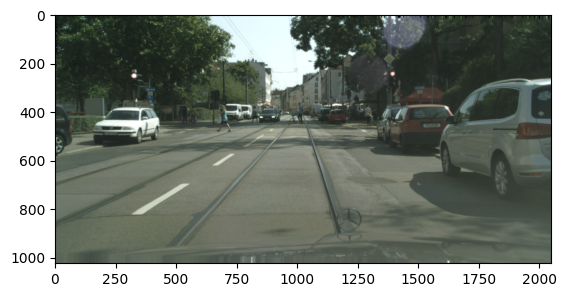

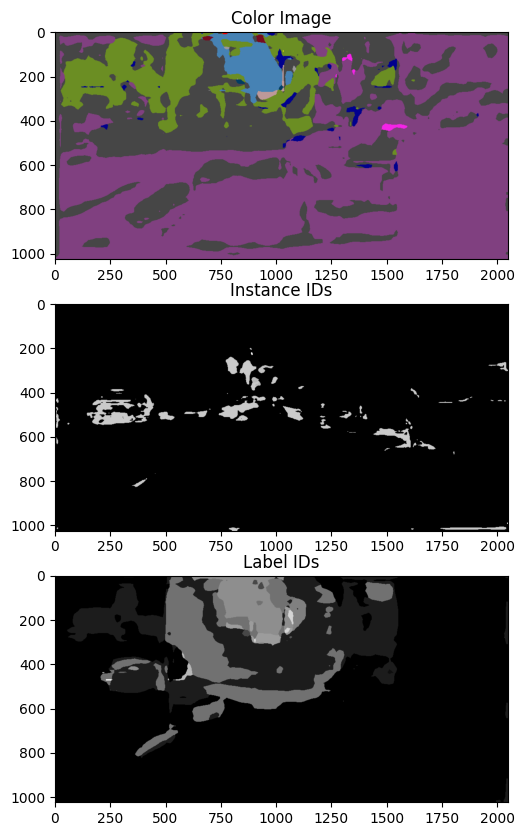

In [143]:
img_path = '/kaggle/input/dsnet-dataset/DSNet/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png'

img = cv2.imread(img_path)

image = Image.open(img_path).convert('RGB')
original_size = image.size

print(original_size)
plt.imshow(image)

input = transform(image).unsqueeze(0).to("cuda")

with torch.no_grad():
    output = model(input)

plt.figure(figsize=(10, 10))
original_size_image = (original_size[1], original_size[0])

for i in range(3):
    channels_tensor = output[i][0]
    output_predictions = channels_tensor.argmax(0)
    output_np = output_predictions.cpu().numpy()

    output_resized = cv2.resize(output_np, (original_size_image[1], original_size_image[0]), interpolation=cv2.INTER_NEAREST)

    plt.subplot(3, 1, i + 1)

    if i == 0:
        height, width = output_resized.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in range(color_map.shape[0]):
            rgb_image[output_resized == class_id] = color_map[class_id]
        plt.imshow(rgb_image)
        plt.title('Color Image')
    elif i == 1:
        height, width = output_resized.shape
        instance_image = np.zeros((height, width), dtype=np.uint8)
        for class_id in range(19):
            if class_id in instance_id:
                instance_image[output_resized == class_id] = instance_color[class_id - 11]
            else:
                instance_image[output_resized == class_id] = 0
        plt.imshow(instance_image, cmap='gray')
        plt.title('Instance IDs')
    else:
        plt.imshow(output_resized, cmap='gray')
        plt.title('Label IDs')

Pixel Accuracy: 0.46929993886898413
Mean Pixel Accuracy: 0.16113486735386984
Intersection over Union: 0.09098649322291018
Frequency Weighted IoU: 0.2259415401914156


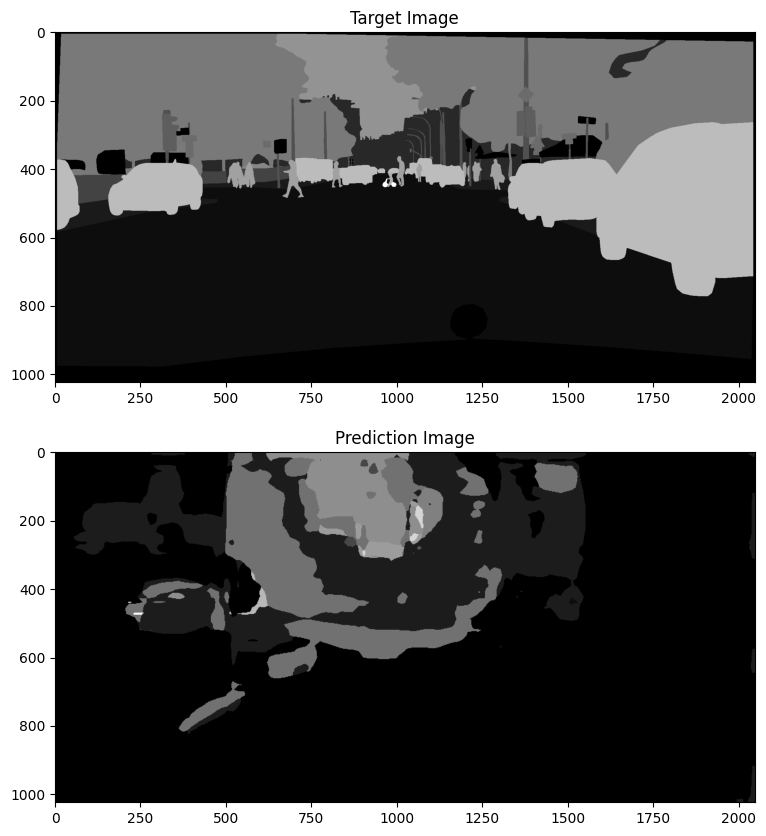

In [144]:
img_true_path = '/kaggle/input/dsnet-dataset/DSNet/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png'

img_true = cv2.imread(img_true_path)
img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)

img_true = np.vectorize(label_mapping.get)(img_true)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")

plt.subplot(2, 1, 2)
plt.imshow(output_resized, cmap='gray')
plt.title("Prediction Image")

evaluate(img_true, output_resized, 19)

# Mô hình pretrained tốt nhất của DSNet trên bộ dữ liệu Cityscape

In [ ]:
model = DSNet(m=2, n=3, num_classes=19, planes=64, name='m',augment=True)
model_dict = model.state_dict()
pretrained_dict = torch.load("/kaggle/input/dsnet-checkpoint/best_dsnet_cityscapes_ 0.8195.pth", weights_only=True)
pretrained_state = {k: v for k, v in pretrained_state.items() if
                            (k in model_dict and v.shape == model_dict[k].shape)}
model_dict.update(pretrained_state)
model.load_state_dict(model_dict, strict=False)

model.eval()
model.to("cuda")

In [41]:
criterion = OhemCrossEntropy(weight=class_weights)
ave_loss, mean_IoU, pixel_acc = validate(model, test_loader, criterion, 19)
print(f'Average loss: {ave_loss:.4f}')
print(f'Pixel Accuracy: {pixel_acc:.4f}')
print(f'Mean Intersection over Union: {mean_IoU:.4f}')

Average loss: 0.9563
Mean Pixel Accuracy: 0.9669
Mean Intersection over Union: 0.8202


(2048, 1024)


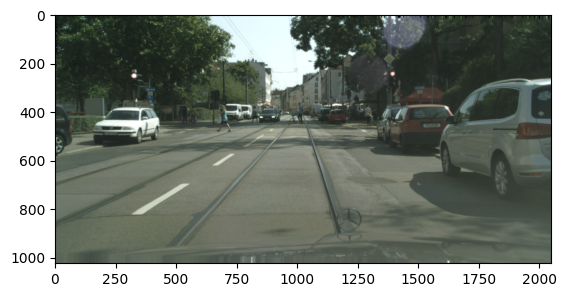

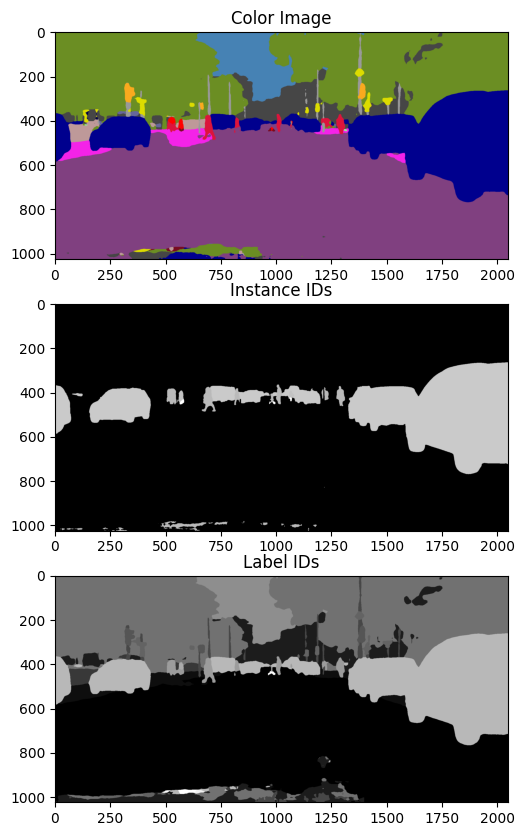

In [47]:
img_path = '/kaggle/input/dsnet-dataset/DSNet/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png'

img = cv2.imread(img_path)

image = Image.open(img_path).convert('RGB')
original_size = image.size

print(original_size)
plt.imshow(image)

input = transform(image).unsqueeze(0).to("cuda")

with torch.no_grad():
    output = model(input)

plt.figure(figsize=(10, 10))
original_size_image = (original_size[1], original_size[0])

for i in range(3):
    channels_tensor = output[i][0]
    output_predictions = channels_tensor.argmax(0)
    output_np = output_predictions.cpu().numpy()

    output_resized = cv2.resize(output_np, (original_size_image[1], original_size_image[0]), interpolation=cv2.INTER_NEAREST)

    plt.subplot(3, 1, i + 1)

    if i == 0:
        height, width = output_resized.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in range(color_map.shape[0]):
            rgb_image[output_resized == class_id] = color_map[class_id]
        plt.imshow(rgb_image)
        plt.title('Color Image')
    elif i == 1:
        height, width = output_resized.shape
        instance_image = np.zeros((height, width), dtype=np.uint8)
        for class_id in range(19):
            if class_id in instance_id:
                instance_image[output_resized == class_id] = instance_color[class_id - 11]
            else:
                instance_image[output_resized == class_id] = 0
        plt.imshow(instance_image, cmap='gray')
        plt.title('Instance IDs')
    else:
        plt.imshow(output_resized, cmap='gray')
        plt.title('Label IDs')

Pixel Accuracy: 0.967224245784586
Mean Pixel Accuracy: 0.6416792161691447
Intersection over Union: 0.48143143045771847
Frequency Weighted IoU: 0.7457742980703587


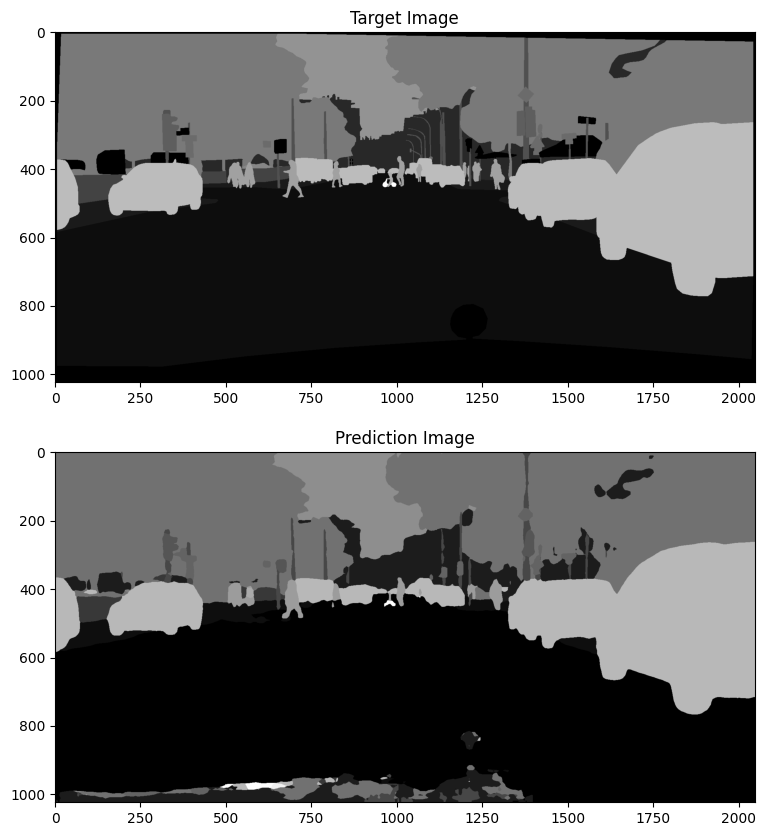

In [44]:
img_true_path = '/kaggle/input/dsnet-dataset/DSNet/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png'

img_true = cv2.imread(img_true_path)
img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)

img_true = np.vectorize(label_mapping.get)(img_true)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")

plt.subplot(2, 1, 2)
plt.imshow(output_resized, cmap='gray')
plt.title("Prediction Image")

evaluate(img_true, output_resized, 19)

# Mô hình sau khi tinh chỉnh hyperparameters


In [51]:
model = DSNet(m=2, n=3, num_classes=19, planes=64, name='m',augment=True)
model_dict = model.state_dict()
pretrained_dict = torch.load("/kaggle/input/dsnet_0/pytorch/default/1/model.pth", weights_only=True)
pretrained_state = {k: v for k, v in pretrained_state.items() if
                            (k in model_dict and v.shape == model_dict[k].shape)}
model_dict.update(pretrained_state)
model.load_state_dict(model_dict, strict=False)

model.eval()
model.to("cuda")
model = nn.DataParallel(model, device_ids=[0,1])

In [52]:
criterion = OhemCrossEntropy(weight=class_weights)
ave_loss, mean_IoU, pixel_acc = validate(model, test_loader, criterion, 19)
print(f'Average loss: {ave_loss:.4f}')
print(f'Mean Pixel Accuracy: {pixel_acc:.4f}')
print(f'Mean Intersection over Union: {mean_IoU:.4f}')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Average loss: 0.9597
Mean Pixel Accuracy: 0.9667
Mean Intersection over Union: 0.8194


(2048, 1024)


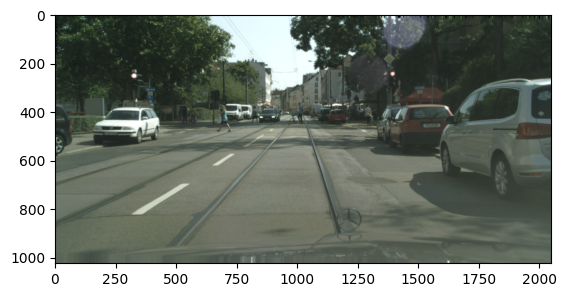

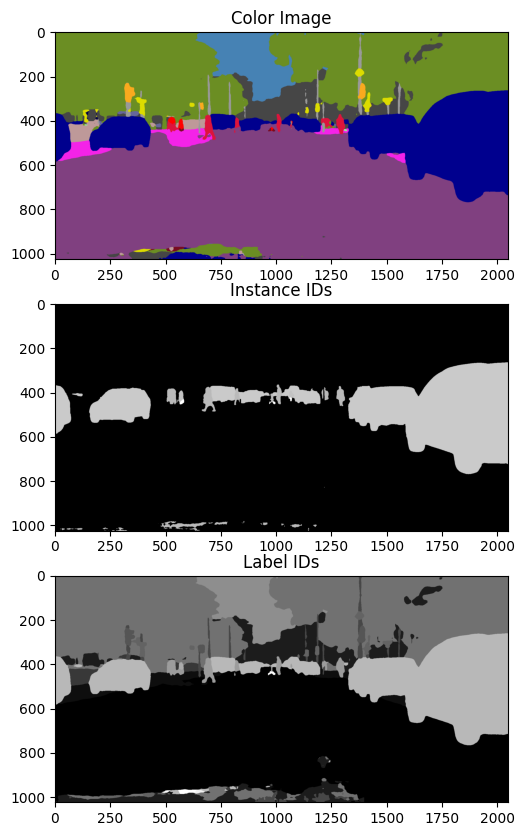

In [57]:
img_path = '/kaggle/input/dsnet-dataset/DSNet/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png'

img = cv2.imread(img_path)

image = Image.open(img_path).convert('RGB')
original_size = image.size

print(original_size)
plt.imshow(image)

input = transform(image).unsqueeze(0).to("cuda")

with torch.no_grad():
    output = model(input)

plt.figure(figsize=(10, 10))
original_size_image = (original_size[1], original_size[0])

for i in range(3):
    channels_tensor = output[i][0]
    output_predictions = channels_tensor.argmax(0)
    output_np = output_predictions.cpu().numpy()

    output_resized = cv2.resize(output_np, (original_size_image[1], original_size_image[0]), interpolation=cv2.INTER_NEAREST)

    plt.subplot(3, 1, i + 1)

    if i == 0:
        height, width = output_resized.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in range(color_map.shape[0]):
            rgb_image[output_resized == class_id] = color_map[class_id]
        plt.imshow(rgb_image)
        plt.title('Color Image')
    elif i == 1:
        height, width = output_resized.shape
        instance_image = np.zeros((height, width), dtype=np.uint8)
        for class_id in range(19):
            if class_id in instance_id:
                instance_image[output_resized == class_id] = instance_color[class_id - 11]
            else:
                instance_image[output_resized == class_id] = 0
        plt.imshow(instance_image, cmap='gray')
        plt.title('Instance IDs')
    else:
        plt.imshow(output_resized, cmap='gray')
        plt.title('Label IDs')

Pixel Accuracy: 0.967224245784586
Mean Pixel Accuracy: 0.6416792161691447
Intersection over Union: 0.48143143045771847
Frequency Weighted IoU: 0.7457742980703587


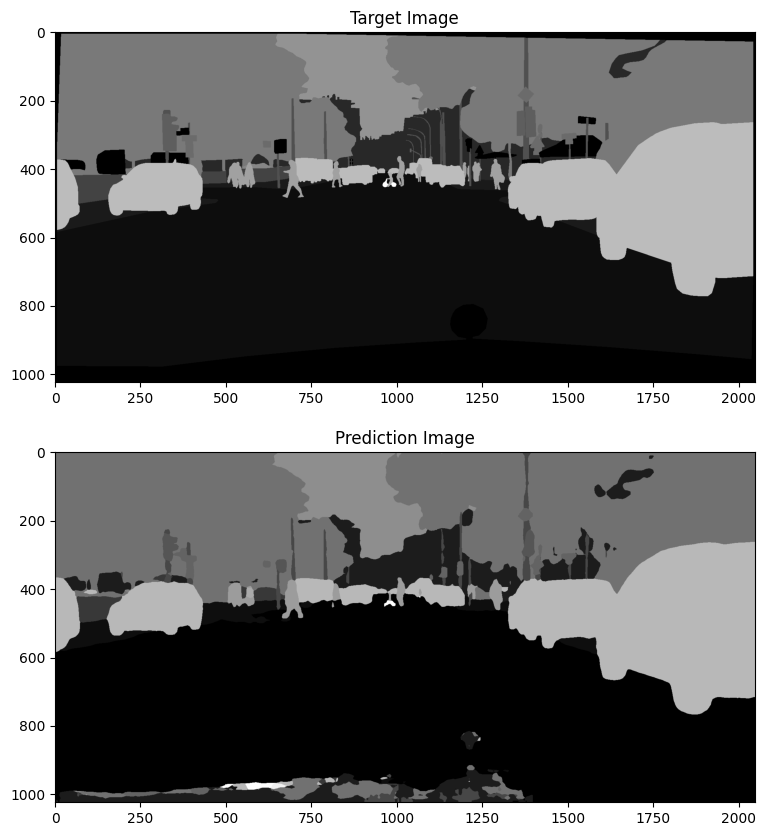

In [58]:
img_true_path = '/kaggle/input/dsnet-dataset/DSNet/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png'

img_true = cv2.imread(img_true_path)
img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)

img_true = np.vectorize(label_mapping.get)(img_true)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")

plt.subplot(2, 1, 2)
plt.imshow(output_resized, cmap='gray')
plt.title("Prediction Image")

evaluate(img_true, output_resized, 19)